# Twitter üzerinde Duygu Analizi
Yunus Emre Gündoğmuş - 21 Mayıs 2020

### Referanslar
- [How to Scrape Tweets From Twitter](https://towardsdatascience.com/how-to-scrape-tweets-from-twitter-59287e20f0f1)
- [Savaş Yıldırım - Bert-base Turkish Sentiment Model](https://huggingface.co/savasy/bert-base-turkish-sentiment-cased)

### Kütüphalerin İçeri Alınması

In [ ]:
!pip install transformers
!pip install tweepy
!pip install tqdm

In [1]:
# Twitter API
import tweepy

# Data Manipulation
from tqdm import tqdm
import pandas as pd
import numpy as np
import time

# Bert Model
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

### Twitter API Ayarlarının Yapılması

In [2]:
# API için Keyler
# API link: https://developer.twitter.com/en/apps

consumer_key = "xxxx"
consumer_secret = "xxxx"
access_token = "xxxx"
access_token_secret = "xxxx"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

### Korona Anahtar kelimesindeki 100 tweet'in çekilmesi

In [3]:
tweets_list = []
text_query = 'Korona'
count = 100

for tweet in api.search(q=text_query, count=count, lang='tr-tr'):
    tweets_list.append((tweet.created_at,tweet.id,tweet.text))

In [4]:
tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
tweets.head()

,Tarih,Tweet_id,Text
0,2020-05-19 16:48:55,1262787328394825729,"RT @GllkMuhammet: Yine bir Milli Bayram, AKP Y..."
1,2020-05-19 16:48:52,1262787318227832833,RT @GkhnKhrman: Türkiye 70 yıllık rüyasını ger...
2,2020-05-19 16:48:44,1262787281636806659,Valla sınavdan sonra korona olursam hiç acımam...
3,2020-05-19 16:48:43,1262787277446676485,"Sağlık Bakanlığı, Türkiye’nin son 24 saatlik k..."
4,2020-05-19 16:48:39,1262787264574341120,RT @agrresifhatun: Korona bizi bitirdin beee


### Eğitilmiş BERT Modeli Kullanarak Duygu Analizinin Yapılması

In [5]:
# Eğitilmiş Ağırlıkların Yüklenmesi
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

In [6]:
sentiment_analysis_pipeline("seni seviyorum")

[{'label': 'LABEL_1', 'score': 0.97204685}]

In [7]:
sentiment_result=[]
for text in tqdm(tweets.Text):
    result = sentiment_analysis_pipeline(text)[0]
    sentiment_result.append(result)

100%|████████████| 100/100 [00:10<00:00,  9.62it/s]


In [8]:
sentiment_result = pd.DataFrame(sentiment_result)
sentiment_result.head()

,label,score
0,LABEL_0,0.992534
1,LABEL_1,0.991454
2,LABEL_1,0.836818
3,LABEL_1,0.617708
4,LABEL_1,0.994455


In [9]:
sentiment_result = pd.DataFrame(sentiment_result)
tweets = pd.concat([tweets, sentiment_result],axis=1)
tweets.label = tweets.label.map({'LABEL_1':1,'LABEL_0':0})
tweets.head()

,Tarih,Tweet_id,Text,label,score
0,2020-05-19 16:48:55,1262787328394825729,"RT @GllkMuhammet: Yine bir Milli Bayram, AKP Y...",0,0.992534
1,2020-05-19 16:48:52,1262787318227832833,RT @GkhnKhrman: Türkiye 70 yıllık rüyasını ger...,1,0.991454
2,2020-05-19 16:48:44,1262787281636806659,Valla sınavdan sonra korona olursam hiç acımam...,1,0.836818
3,2020-05-19 16:48:43,1262787277446676485,"Sağlık Bakanlığı, Türkiye’nin son 24 saatlik k...",1,0.617708
4,2020-05-19 16:48:39,1262787264574341120,RT @agrresifhatun: Korona bizi bitirdin beee,1,0.994455


### Hepsini Bir araya Getirelim

In [10]:
class TwitterSentimentAnalyser:
    def __init__(self, consumer_key, consumer_secret, access_token, access_token_secret, keyword, tweetCount):
        self.keyword = keyword
        self.consumer_key = consumer_key
        self.consumer_secret = consumer_secret
        self.access_token = access_token
        self.access_token_secret = access_token_secret
        self.tweetCount = tweetCount
        
    def getTwitterData(self):
        tweets_list = []
        
        for tweet in api.search(q=self.keyword, count=self.tweetCount, lang='tr-tr'):
            tweets_list.append((tweet.created_at,tweet.id,tweet.text))
            
        self.tweets = pd.DataFrame(tweets_list, columns=["Tarih",'Tweet_id','Text'])
            
    def bertPipeline(self):
        # Eğitilmiş Ağırlıkların Yüklenmesi
        model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
        tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")

        self.sentiment_analysis_pipeline= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)
        
    def sentimentPrediction(self):
        self.sentiment_result=[]
        for text in tqdm(self.tweets.Text):
            result = sentiment_analysis_pipeline(text)[0]
            self.sentiment_result.append(result)
        
        self.sentiment_result = pd.DataFrame(self.sentiment_result)
        self.tweets = pd.concat([self.tweets, self.sentiment_result],axis=1)
        self.tweets.label = self.tweets.label.map({'LABEL_1':1,'LABEL_0':0})

In [11]:
twst = TwitterSentimentAnalyser(consumer_key = "xxxx", consumer_secret = "xxxx",
                                access_token = "xxxx", access_token_secret = "xxxx",
                                keyword='korona', tweetCount=100)

In [12]:
twst.getTwitterData()
twst.tweets.head()

,Tarih,Tweet_id,Text
0,2020-05-19 16:49:07,1262787381473808384,RT @GkhnKhrman: Türkiye 70 yıllık rüyasını ger...
1,2020-05-19 16:49:07,1262787379489800192,RT @veryansintvcom: İnsan çipleme projesi durd...
2,2020-05-19 16:49:06,1262787375131959299,RT @seyhmusaydinn: Korona virüs salgın riskine...
3,2020-05-19 16:49:05,1262787373559156743,@neredelanbuege @allahimnasipet @cocuktrr @evr...
4,2020-05-19 16:48:55,1262787328394825729,"RT @GllkMuhammet: Yine bir Milli Bayram, AKP Y..."


In [13]:
twst.bertPipeline()

In [14]:
twst.sentimentPrediction()
twst.tweets.head()

100%|████████████| 100/100 [00:11<00:00,  8.65it/s]


,Tarih,Tweet_id,Text,label,score
0,2020-05-19 16:49:07,1262787381473808384,RT @GkhnKhrman: Türkiye 70 yıllık rüyasını ger...,1,0.991454
1,2020-05-19 16:49:07,1262787379489800192,RT @veryansintvcom: İnsan çipleme projesi durd...,1,0.619394
2,2020-05-19 16:49:06,1262787375131959299,RT @seyhmusaydinn: Korona virüs salgın riskine...,1,0.898994
3,2020-05-19 16:49:05,1262787373559156743,@neredelanbuege @allahimnasipet @cocuktrr @evr...,0,0.593836
4,2020-05-19 16:48:55,1262787328394825729,"RT @GllkMuhammet: Yine bir Milli Bayram, AKP Y...",0,0.992534


In [15]:
print(f"Korona Hakkında {twst.tweets.Tarih.min()} ile {twst.tweets.Tarih.max()} arasında atılan Tweetlerin Pozitiflik Oranı: {twst.tweets.label.mean()}")

Korona Hakkında 2020-05-19 16:42:26 ile 2020-05-19 16:49:07 arasında atılan Tweetlerin Pozitiflik Oranı: 0.58


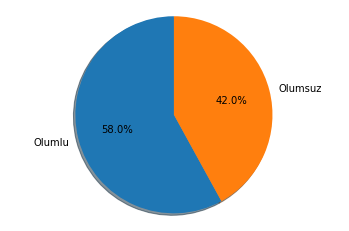

In [17]:
import matplotlib.pyplot as plt

labels = twst.tweets.label.map({1:'Olumlu',0:'Olumsuz'}).value_counts().index.values
sizes = twst.tweets.label.value_counts().values

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()